<a id='section_id4'></a>
# Collaborative Filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

![title](images/collaborative.jpeg)

Netflix Prize dataset is a movies rating dataset released in October 2006. It contains 100 million ratings of 17,700 movies by 480,189 users. The ratings are on a scale from 1 to 5.

The data consists of two tables : ratings and movie titles. 

Dataset url: https://www.kaggle.com/netflix-inc/netflix-prize-data#combined_data_1.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Reader, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split

%matplotlib inline

To display all the information from the columns and rows.

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Load CSV File

In [3]:
df = pd.read_csv('./netflix-prize-data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [4]:
df['Rating'] = df['Rating'].astype(float)
df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0         1:      NaN    
5000000   2560324  4.0   
10000000  2271935  2.0   
15000000  1921803  2.0   
20000000  1933327  3.0   


CustomerID,Rating,Date
- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

In [5]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [6]:
df.isnull().sum()

Cust_Id    0   
Rating     4499
dtype: int64

There are 4,499 null values in the Ratings column.

In [7]:
df.shape

(24058263, 2)

The dataset has 24,058,263 rows and 2 columns.

In [8]:
df_title = pd.read_csv('./netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


In [9]:
df_title.shape

(17770, 2)

The movie title dataset has 17,770 rows and 2 columns.

MovieID,YearOfRelease,Title
- MovieID do not correspond to actual Netflix movie ids or IMDB movie ids.
- YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release.
- Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English.

## Data Cleaning & EDA

First, we need to transform the dataframe of ratings into a proper format that can be consumed by a KNN model. We want the data to be in an m x n array, where m is the number of movies and n is the number of users. To reshape dataframe of ratings, we’ll pivot the dataframe to the wide format with movies as rows and users as columns. Then we’ll fill the missing observations with 0s since we’re going to be performing linear algebra operations (calculating distances between vectors).

Removing all null values in the Ratings column and combining both tables into a single DataFrame.

In [10]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] -1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [11]:
movie_np

array([1.000e+00, 1.000e+00, 1.000e+00, ..., 4.499e+03, 4.499e+03,
       4.499e+03])

In [12]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]
df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
df1 = df
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844  3.0     1       
5000996   501954   2.0     996     
10001962  404654   5.0     1962    
15002876  886608   2.0     2876    
20003825  1193835  2.0     3825    


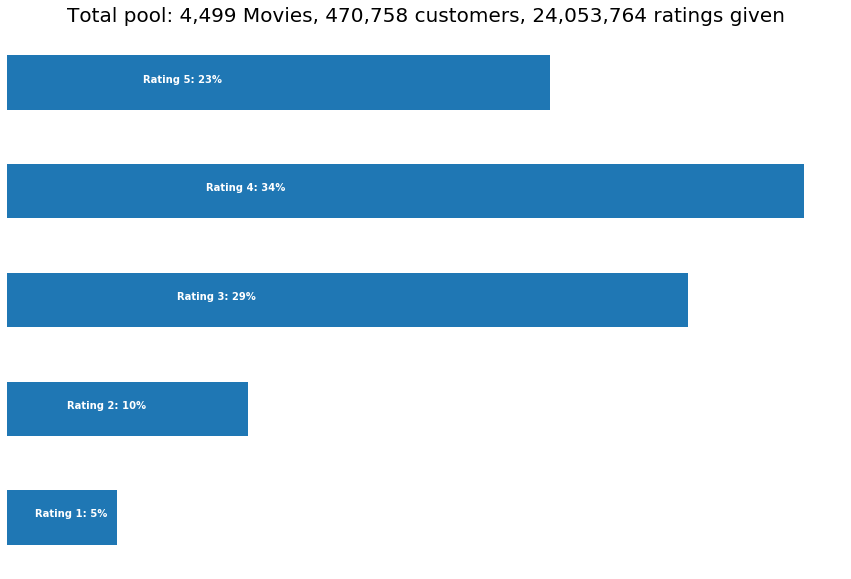

In [13]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df['Movie_Id'].nunique()

# get customer count
cust_count = df['Cust_Id'].nunique()

# get rating count
rating_count = df['Cust_Id'].count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

The total pool consists of 4,499 movies, 470,758 users and 24,053,764 movie ratings given with the majority (34%) of movie ratings being a 4.

In [15]:
counts1 = df['Cust_Id'].value_counts()
df = df[df['Cust_Id'].isin(counts1[counts1 >= 100].index)]
df.head()

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
4,30878,4.0,1
5,823519,3.0,1
6,893988,3.0,1
8,1248029,3.0,1


Removing all customers who do not have above or equal to 100 movie ratings for a fairer representation of the dataset and computational efficiency.

In [16]:
df.shape

(13254584, 3)

The dataset now has 13,254,584 rows and 3 columns.

In [17]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id').fillna(0)
df_p.head(10)

Movie_Id    1    2    3    4    5    6    7    8    9   10   11   12   13  \
Cust_Id                                                                     
6         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0   
79        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
134       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
188       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
199       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
265       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
283       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
383       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Movie_Id   14   15   16   17   18   19   20   21   22   23   24   25   26  \
Cust_Id                                                                     
6         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
79        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
134       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
188       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
199       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
265       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
283       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
383       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Movie_Id   27   28   29   30   31   32   33   34   35   36   37   38   39  \
Cust_Id                                                                     
6         0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7         0.0  4.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
79        0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
134       0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
188       0.0  0.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
199       0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
265       0.0  3.0  0.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
283       0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
383       0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Movie_Id   40   41   42   43   44   45   46   47   48   49   50   51   52  \
Cust_Id                                                                     
6         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
79        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
134       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
188       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
199       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
265       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
283       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
383       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Movie_Id   53   54   55   56   57   58   59   60   61   62   63   64   65  \
Cust_Id                                                                     
6         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

Creating a sparse matrix of Customer ID and Movie ID with Movie Ratings as the values.

In [18]:
df_p.shape

(71241, 4499)

## Algorithms Benchmarking

In [19]:
reader = Reader()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:10000], reader)
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,1.216071,1.382292,0.333883
BaselineOnly,1.222068,0.017896,0.031703
SVD,1.222787,0.356491,0.014834
SVDpp,1.247329,0.609142,0.018480
KNNBasic,1.249741,1.333762,0.306524
KNNWithMeans,1.254538,1.372679,0.318973
KNNWithZScore,1.264637,1.489564,0.300541
NMF,1.275689,0.618214,0.027060
SlopeOne,1.278513,0.051408,0.015794


Based on the above Algorithm Benchmarking, **KNNBaseline** appears to be performing the best in terms of predicting user ratings on unrated movies with the lowest Root Mean Squared Error (RMSE) and reasonable computational efficiency in terms of model fitting & testset timings.

## Collaborative Filtering - k-Nearest Neighbors Baseline (kNNBaseline)

To implement an item based collaborative filtering, KNN is a perfect go-to model and also a very good baseline for recommender system development. KNN is a non-parametric, lazy learning method. It uses a database in which the data points are separated into several clusters to make inference for new samples.

KNN does not make any assumptions on the underlying data distribution but it relies on item feature similarity. When KNN makes inference about a movie, KNN will calculate the “distance” between the target movie and every other movie in its database, then it ranks its distances and returns the top K nearest neighbor movies as the most similar movie recommendations.


_Illustration of how KNN makes classification about new sample_
![Title](images/knn.png)


In [20]:
print('Using ALS')
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:10000], reader)
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = KNNBaseline(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.21842159, 1.20923552, 1.21861578]),
 'fit_time': (1.3442049026489258, 1.269455909729004, 1.3778190612792969),
 'test_time': (0.372020959854126, 0.3088572025299072, 0.2682948112487793)}

In [21]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = KNNBaseline(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1960


1.1959587930630866

In [22]:
def get_Iu(uid):
    """ return the number of movies rated by given customer
    args: 
      uid: the id of the customer
    returns: 
      the number of movies rated by the customer
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:
        return 0
    
def get_Ui(iid):
    """ return number of customers that have rated given movie
    args:
      iid: the raw id of the movie
    returns:
      the number of customers that have rated the movie.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df2 = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df2['Iu'] = df2.uid.apply(get_Iu)
df2['Ui'] = df2.iid.apply(get_Ui)
df2['err'] = abs(df2.est - df2.rui)
best_predictions = df2.sort_values(by='err')[:10]
worst_predictions = df2.sort_values(by='err')[-10:]

In [23]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1721,2118461,13,5.0,5.000000,"{'actual_k': 3, 'was_impossible': False}",7,43,0.000000
962,867021,13,5.0,5.000000,"{'actual_k': 4, 'was_impossible': False}",1,43,0.000000
1835,575714,8,3.0,2.995340,"{'actual_k': 40, 'was_impossible': False}",1,4392,0.004660
1556,872126,8,3.0,2.995340,"{'actual_k': 40, 'was_impossible': False}",1,4392,0.004660
1010,555509,8,3.0,2.995340,"{'actual_k': 40, 'was_impossible': False}",1,4392,0.004660
1204,1772215,12,3.0,3.008203,"{'actual_k': 31, 'was_impossible': False}",1,317,0.008203
2155,1782553,14,3.0,2.991037,"{'actual_k': 8, 'was_impossible': False}",1,43,0.008963
1447,504620,1,2.0,1.986581,"{'actual_k': 12, 'was_impossible': False}",1,250,0.013419
714,2444204,8,3.0,2.986474,"{'actual_k': 40, 'was_impossible': False}",1,4392,0.013526
989,1948594,8,3.0,2.986474,"{'actual_k': 40, 'was_impossible': False}",1,4392,0.013526


In [24]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1822,1783814,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
1424,1792137,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
1148,938804,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
1833,480612,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
1289,1458517,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
1956,1634594,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
2206,1815614,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
2262,229971,5,1.0,3.753094,{'was_impossible': False},0,415,2.753094
334,491531,5,1.0,3.773452,"{'actual_k': 23, 'was_impossible': False}",2,415,2.773452
818,491531,7,5.0,2.148751,"{'actual_k': 6, 'was_impossible': False}",2,47,2.851249


Let's take a closer look at some of the worst predictions to get an idea of why our model is giving us a bad estimate!

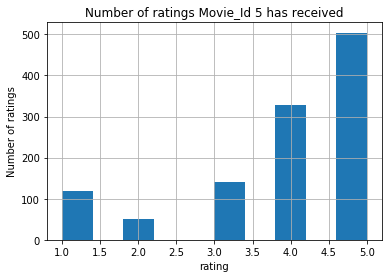

In [25]:
df1.loc[df1['Movie_Id'] == 5]['Rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Movie_Id 5 has received')
plt.show();

It appears that there seems to be some rating outliers within Movie_Id 5 given by customers, either due to it being a polarizing movie or possible data distortion. Hence, our model is giving us a bad estimate.

## Testing the Recommendations

In [44]:
f = ['count','mean']
df_movie_summary = df2.groupby('iid')['est'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)

In [45]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][1:11].to_string(index=False))

In [46]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                              Name  count      mean
 0.038149  Sick                              131.0  3.100740
 0.035427  Character                         279.0  3.553407
 0.016064  Full Frame: Documentary Shorts    20.0   2.776332
 0.011349  Screamers                         120.0  3.046643
 0.011296  My Favorite Brunette              119.0  3.363058
 0.010994  Dinosaur Planet                   68.0   3.416132
 0.010303  Class of Nuke 'Em High 2          19.0   2.516688
 0.010007  Isle of Man TT 2004 Review        10.0   2.386080
 0.008172  Fighter                           27.0   2.885987
 0.006889  Neil Diamond: Greatest Hits Live  31.0   3.009788


In [47]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                                         Name  count      mean
 0.038988  The Rise and Fall of ECW                                                     123.0  3.652886
 0.015620  Dinosaur Planet                                                              68.0   3.416132
 0.010603  Lord of the Rings: The Return of the King: Extended Edition: Bonus Material  16.0   4.639913
 0.008148  Class of Nuke 'Em High 2                                                     19.0   2.516688
 0.006831  Paula Abdul's Get Up & Dance                                                 20.0   2.593099
 0.006670  8 Man                                                                        18.0   2.019114
 0.004348  Nature: Antarctica                                                           10.0   2.682486
 0.002616  Isle of Man TT 2004 Review                                       

## Conclusion

In this project, a dataset from the Netflix Prize was used to create a recommendation system.

A few different approaches were investigated, including memory-based collaborative filtering and model-based matrix factorisation, but KNNBaseline was eventually chosen.

It should be noted that this approach still suffers from the "cold start problem". - that is, for users with no ratings or history the model will not make proper recommendation.

One way we could tackle this problem may be to initially start with popularity-based recommendations, before building up enough user history to implement the model.

Due to some threshold, we have reduced the dataset. Its mainly because of the memory error and computation time of the laptop.

## References

- https://www.businessinsider.sg/netflix-recommendation-engine-worth-1-billion-per-year-2016-6?r=US&IR=T
- https://variety.com/2020/digital/news/netflix-2020-content-spending-17-billion-1203469237/